# MNIST Fashion classification with convolutional neural network

Study the Convolutionnal neural network (CNN) tutorial of Keras on the classification of the MNIST Fashion Dataset

Learning goals:
- Understand the model structure
- Evaluate and enhance the model
- Use checkpoints
- Use several kinds of regularizers to improve the generalization (kernel/bias, dropout, dataset augmentation)

To compare with the [Dense (Perceptron) only implementation](../classification/ClassificationMultiMnistFashion.html) ([Notebook](../classification/ClassificationMultiMnistFashion.ipynb))

In [0]:
# !pip install tensorview

In [3]:
from tensorflow.keras import models, layers, losses, activations, regularizers, preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import tensorview as tv

# Patch for macOS + Conda
if True:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

Using the fashion MNIST dataset from https://github.com/zalandoresearch/fashion-mnist
It is made of 70k pictures classified in 10 categories. 
Images are greyscale, 28x28 pixels.

The train/test split is 60/10

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

image_width = 28
image_height = 28
image_nchannels = 1
n_classes = len(class_names)

batch_size = 128

In [6]:
train_images.shape

(60000, 28, 28)

Reshaping to get a tensor with the channels, and scaling the 8 bit pixels of the images to float values in [0,1)

In [0]:
train_images = train_images.reshape(60000, image_width, image_height, image_nchannels) / 128.0 - 0.5
test_images = test_images.reshape(10000, image_width, image_height, image_nchannels) / 128.0 - 0.5

## Helpers

In [0]:
# Keras tuto helpers
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i].reshape(image_width, image_height)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [0]:
def plot_results(images, labels, predictions, num_rows=5, num_cols=3):
    """ Plot the first X test images, their predicted label, and the true label
        Color correct predictions in blue, incorrect predictions in red"""
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions, labels, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions, labels)
    plt.show() 

In [0]:
def plotHeatMap(X, classes='auto', title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None,
               vmin=None, vmax=None, cbar=True):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, 
                     fmt=fmt, vmin=vmin, vmax=vmax, cbar=cbar, cmap=plt.cm.Reds, ax=ax) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    """ Compute and plot the confusion matrix """
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, \
                xlabel='Estimations', ylabel='True values');

# 2D Convolutional neural network (CNN)

https://www.tensorflow.org/beta/tutorials/images/intro_to_cnns  

In [11]:
model1 = models.Sequential([
    # Single image channel
    layers.Conv2D(32, (3, 3), activation=activations.relu, 
                        input_shape=(image_width, image_height, image_nchannels)), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation=activations.relu),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation=activations.relu),
    layers.Flatten(),
    layers.Dense(64, activation=activations.relu),
    layers.Dense(10, activation=activations.softmax)
], 'model1')

model1.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                36928

In [0]:
nEpochs = 25

callbacks = [
    ModelCheckpoint(
        filepath='checkpoints_cnn-mnistfashion/model1_{epoch}',
        save_best_only=False,
        verbose=1),
    tv.train.PlotMetricsOnEpoch(metrics_name=['Cross-entropy', 'Accuracy'],
                               cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
]

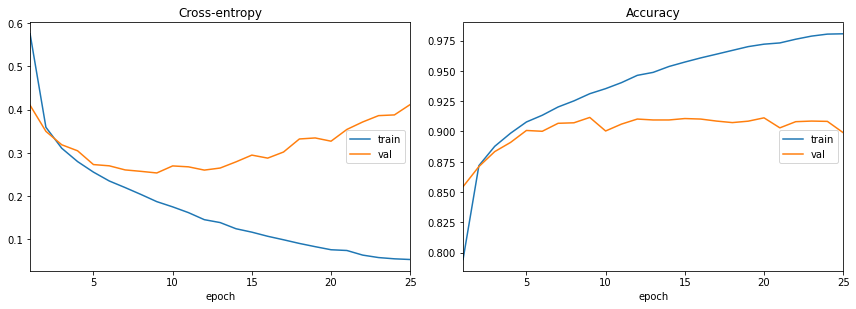

In [13]:
hist1 = model1.fit(train_images, train_labels, 
                   epochs=nEpochs, validation_split=0.2, batch_size=batch_size,
                   verbose=0, callbacks=callbacks)

In [14]:
test_loss1, test_acc1 = model1.evaluate(test_images, test_labels, verbose=0)
print('Test categorical cross-entropy: {:.3f}, accuracy: {:.3f}'.format(test_loss1, test_acc1))

Test categorical cross-entropy: 0.418, accuracy: 0.900


Here again there is a difference between the training and validation or test accuracies.

The result is quite lower compared to the referenced tutorial (claiming 99% test accuracy). Is this due to the use of Tensorflow 1.14 vs. 2.0-beta ?

As on the classical model, there is probably overfitting.

Here is the histogram of the ceofficients of the Dense layer of 64 neurons:

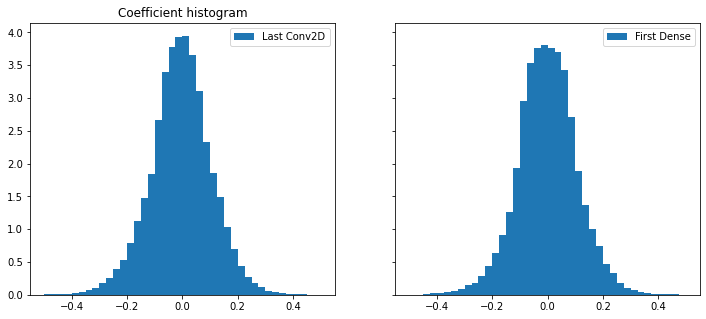

In [15]:
weights1 = model1.get_weights()
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axes[0].hist(weights1[4].reshape(-1), bins=40, range=(-0.5, 0.5), density=True, label='Last Conv2D');
axes[0].set_title('Coefficient histogram');
axes[0].legend()
axes[1].hist(weights1[6].reshape(-1), bins=40, range=(-0.5, 0.5), density=True, label='First Dense');
axes[1].legend();

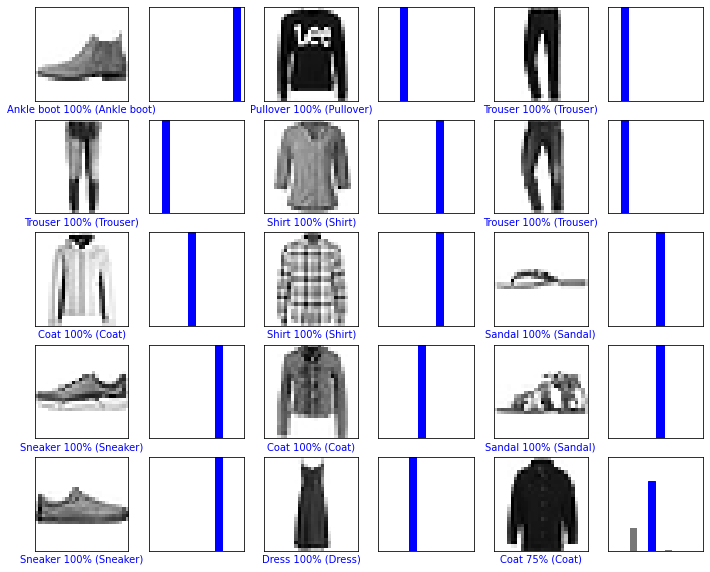

In [16]:
predictions1 = model1.predict(test_images[:15])
plot_results(test_images, test_labels, predictions1)

## CNN with regularizer

Let's apply Dropout on the two largest layers, and decrease the size of the last Conv2D and the 1st Dense layers from 64 to 48.

In [17]:
model2 = models.Sequential([
    # Single image channel
    layers.Conv2D(32, (3, 3), activation=activations.relu, 
                input_shape=(image_width, image_height, image_nchannels)), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),                                      # <---
    layers.Conv2D(64, (3, 3), activation=activations.relu),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),                                      # <---
    layers.Conv2D(48, (3, 3), activation=activations.relu),   # <---
    layers.Flatten(),
    layers.Dense(48, activation=activations.relu),            # <---
    layers.Dense(10, activation=activations.softmax)
], 'model2')

model2.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model2.summary()

Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 48)          27696

In [0]:
nEpochs = 25

callbacks = [
    ModelCheckpoint(
        filepath='checkpoints_cnn-mnistfashion/model2_{epoch}',
        save_best_only=False,
        verbose=1),
    tv.train.PlotMetricsOnEpoch(metrics_name=['Cross-entropy', 'Accuracy'],
                               cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
]

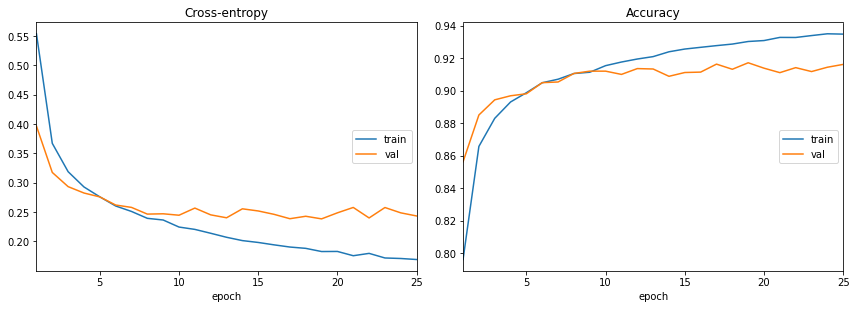

In [19]:
hist2 = model2.fit(train_images, train_labels, 
                   epochs=nEpochs, validation_split=0.2, 
                   verbose=0, callbacks=callbacks)

In [20]:
print('Final train accuracy: {:.3f}'.format(hist2.history['Accuracy'][-1]))

Final train accuracy: 0.935


In [21]:
test_loss2, test_acc2 = model2.evaluate(test_images, test_labels, verbose=0)
print('Test categorical cross-entropy: {:.3f} accuracy: {:.3f}'.format(test_loss2, test_acc2))

Test categorical cross-entropy: 0.267 accuracy: 0.911


Train accuracy is a little lower, __test accuracy is the same as with the bigger model__.

Coefficients are better spread on the layers with regularizers

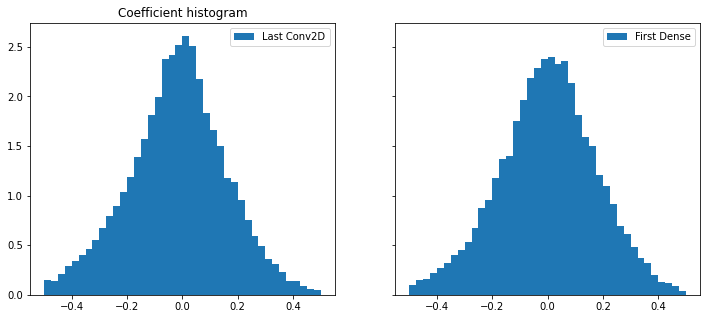

In [22]:
weights2 = model2.get_weights()
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axes[0].hist(weights2[4].reshape(-1), bins=40, range=(-0.5, 0.5), density=True, label='Last Conv2D');
axes[0].set_title('Coefficient histogram');
axes[0].legend()
axes[1].hist(weights2[6].reshape(-1), bins=40, range=(-0.5, 0.5), density=True, label='First Dense');
axes[1].legend();

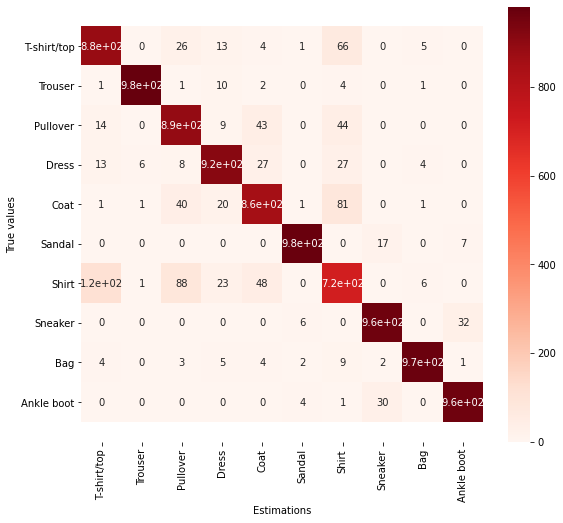

In [23]:
predictions2 = model2.predict(test_images)

fig, ax = plt.subplots(figsize=(9, 8))
plotConfusionMatrix(test_labels, np.argmax(predictions2, axis=1), class_names)

## Padding the input

Observation of activation maps with the [DNN Viewer](https://github.com/tonio73/dnnviewer/) have shown that some detected contours within the convolutionnal layers might fall of the image raster since the image crop is quite tight.

Input image (boot):
![Input boot](assets/fashion-mnist-boot.png)

Convolution activation at layer 1 (example), the right and contour is too close to the image border:
![Input boot](assets/fashion-mnist-boot_l1-contour.png)

Let's try a model with padding at the input : 4 more pixels on each on the 4 image sides.

In [28]:
image_width_pad = image_width + 8
image_height_pad = image_height + 8

model3 = models.Sequential([
    # Single image channel
    layers.Conv2D(32, (3, 3), activation=activations.relu, 
                input_shape=(image_width_pad, image_height_pad, image_nchannels)),  # <---
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),                                      # <---
    layers.Conv2D(64, (3, 3), activation=activations.relu),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),                                      # <---
    layers.Conv2D(48, (3, 3), activation=activations.relu),  
    layers.Flatten(),
    layers.Dropout(0.2), 
    layers.Dense(48, activation=activations.relu),           
    layers.Dense(10, activation=activations.softmax)
], 'model3')

model3.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model3.summary()

Model: "model3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 34, 34, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 5, 5, 48)          27696

In [0]:
nEpochs = 50

callbacks = [
    ModelCheckpoint(
        filepath='checkpoints_cnn-mnistfashion/model3_{epoch}',
        save_best_only=False,
        verbose=1),
    tv.train.PlotMetricsOnEpoch(metrics_name=['Cross-entropy', 'Accuracy'],
                               cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
]

In [0]:
pad3 = [[0, 0], [4, 4], [4, 4], [0, 0]]
train_images_pad = np.pad(train_images, pad3, constant_values=-0.5)
test_images_pad = np.pad(test_images, pad3, constant_values=-0.5)

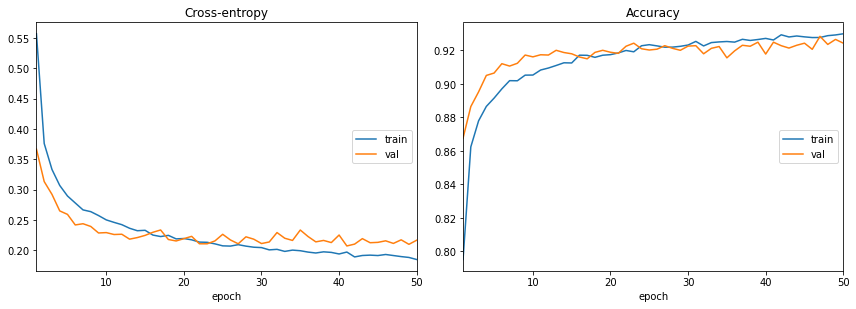

In [31]:
hist3 = model3.fit(train_images_pad, train_labels, 
                   epochs=nEpochs, validation_split=0.2, 
                   verbose=0, callbacks=callbacks)

Overfitting is present from epoch #10, early stopping would have been beneficial

In [32]:
test_loss3, test_acc3 = model3.evaluate(test_images_pad, test_labels, verbose=0)
print('Test loss: {:.3f}, accuracy: {:.3f}'.format(test_loss3, test_acc3))

Test loss: 0.234, accuracy: 0.921


In [0]:
predictions3 = model3.predict(test_images_pad)

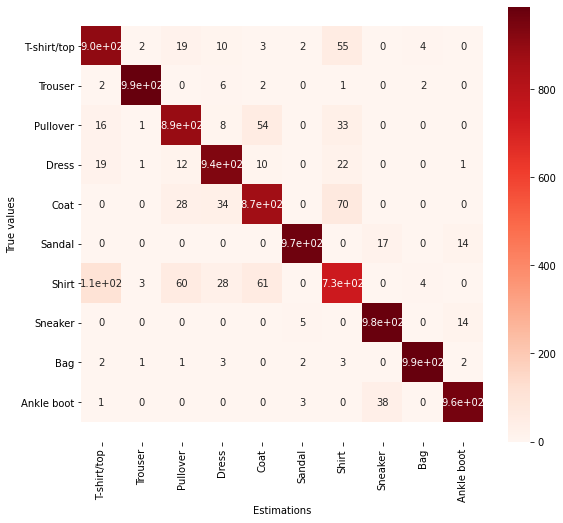

In [34]:
fig, ax = plt.subplots(figsize=(9, 8))
plotConfusionMatrix(test_labels, np.argmax(predictions3, axis=1), class_names)

Intuition was good, ~1% performance increase with same architecture and padded input.

## Using data augmentation

Data augmentation is increasing the size of a training dataset by adding some modified versions of the images, see [4] and [5] for a survey of available technics.

Since the training set is larger, overfitting should be smaller, meaning data augmentation acts as regularization.

Below, we will use the inline technic through the preprocessor of Keras [3]

In [0]:
batch_size = 128
steps_per_epoch = len(train_images) // batch_size
nEpochs = 50

# Image preprocessor
data_gen4 = preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False) # All clothes and shoes are the same direction

# For validation data
data_gen4v = preprocessing.image.ImageDataGenerator()

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#data_gen4.fit(train_images)
#data_gen4v.fit(train_images)

The capacity (size) of the model is set back to the one of model1 (32, 64, 64, 64, 10), inserting dropout as in model3

In [0]:
model4 = models.Sequential([
    # Single image channel
    layers.Conv2D(32, (3, 3), activation=activations.relu, 
                input_shape=(image_width_pad, image_height_pad, image_nchannels)),  # <---
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),                                      # <---
    layers.Conv2D(64, (3, 3), activation=activations.relu),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),                                      # <---
    layers.Conv2D(64, (3, 3), activation=activations.relu),  
    layers.Flatten(),
    layers.Dropout(0.2), 
    layers.Dense(64, activation=activations.relu),           
    layers.Dense(10, activation=activations.softmax)
], 'model4')
model4.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [0]:
callbacks = [
    ModelCheckpoint(
        filepath='checkpoints_cnn-mnistfashion/model4_{epoch}',
        save_best_only=False,
        verbose=1),
    tv.train.PlotMetricsOnEpoch(metrics_name=['Cross-entropy', 'Accuracy'],
                               cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)
]

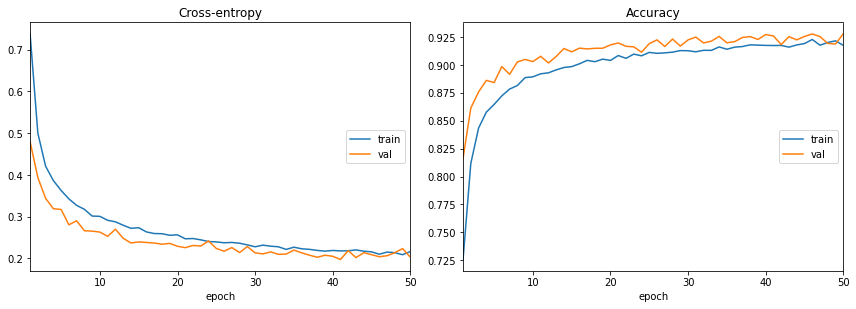

In [41]:
# fits the model on batches with real-time data augmentation:
data_gen_flow4 = data_gen4.flow(train_images_pad, train_labels, batch_size=batch_size)
data_gen_flow4v = data_gen4v.flow(test_images_pad, test_labels, batch_size=batch_size)
hist4 = model4.fit_generator(data_gen_flow4, 
                    steps_per_epoch * 0.75, epochs=nEpochs, 
                    validation_data=data_gen_flow4v, validation_steps=steps_per_epoch * 0.25,
                    verbose=0, callbacks=callbacks)

The validation performance is as expected better than the training one since the validation data is not augmented, thus the problem to solve is easier.

There is still indication of overfitting when the validation curve is flattening while training performance is still increasing.

In [42]:
print('Final train accuracy: {:.3f}'.format(hist4.history['Accuracy'][-1]))

Final train accuracy: 0.917


Test data is not augmented and shall have a lower loss, better accuracy:

In [43]:
test_loss4, test_acc4 = model4.evaluate(test_images_pad, test_labels, verbose=0)
print('Test loss: {:.3f}, accuracy: {:.3f}'.format(test_loss4, test_acc4))

Test loss: 0.208, accuracy: 0.926


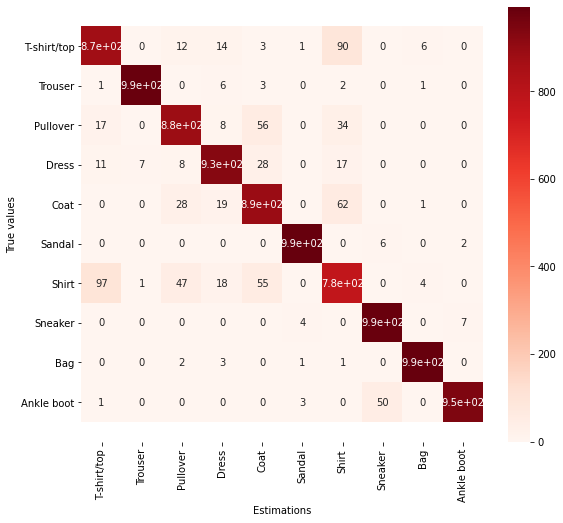

In [44]:
predictions4 = model4.predict(test_images_pad)
fig, ax = plt.subplots(figsize=(9, 8))
plotConfusionMatrix(test_labels, np.argmax(predictions4, axis=1), class_names)

With image augmentation overfitting is lower. 

This technique is improving accuracy by 0.5% but is also very coslty in processing time.

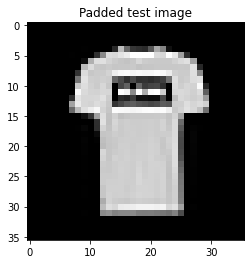

In [45]:
plt.imshow(train_images_pad[1].squeeze(), cmap='gray')
plt.title('Padded test image');

# Conclusion

Starting from a simple model provided by a tutorial, we have seen how to improve it by regularization (Dropout), fine tuning of the input data, and image augmentation.

Final score is a little higher, but most of all overfitting is way lower meaning a more robust model.

## References:
1. [Introduction to CNNs - Tensorflow/Keras](https://www.tensorflow.org/beta/tutorials/images/intro_to_cnns)
2. [Keras Conv2D and Convolutional layer - PyImageSearch](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)
3. [Image preprocessing - Tensorflow/Keras](https://keras.io/preprocessing/image/)
4. [Keras ImageDataGenerator and Data Augmentation - PyImageSearch](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)
5. [Classify butterfly images with deep learning in Keras](https://towardsdatascience.com/classify-butterfly-images-with-deep-learning-in-keras-b3101fe0f98)
6. [Fashion MNIST with Keras and Deep Learning - PyImageSearch](https://www.pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/)